In [7]:
sentences = ['i feel hungry','i eat lunch','now i feel happy']

word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
index_to_word={}

# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
word_to_index = {word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])

4


In [5]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [8]:
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [9]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [10]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# encoded_sentences=[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 가 아래와 같이 변환됩니다.
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


In [11]:
import numpy as np
import tensorflow as tf
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
output = embedding(raw_inputs)
print(output)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [12]:
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                          value = word_to_index['<PAD>'],
                                                          padding = 'post',
                                                           maxlen = 5)

In [13]:
print(raw_inputs)

[[1 3 4 5 0]
 [1 3 6 7 0]
 [1 8 3 4 9]]


In [14]:
output = embedding(raw_inputs)
print(output)

tf.Tensor(
[[[ 0.04768148  0.00018213 -0.01457737 -0.00805289]
  [ 0.01846118  0.01463265 -0.03945919 -0.03796645]
  [ 0.02636036 -0.00728557 -0.01322871  0.04761031]
  [-0.01114477 -0.03798773  0.00039115 -0.04627573]
  [-0.02425346  0.02390163 -0.04418124 -0.04404001]]

 [[ 0.04768148  0.00018213 -0.01457737 -0.00805289]
  [ 0.01846118  0.01463265 -0.03945919 -0.03796645]
  [-0.01649185 -0.00404651 -0.01921253  0.01382356]
  [ 0.01039783 -0.04238302 -0.00084438  0.02773966]
  [-0.02425346  0.02390163 -0.04418124 -0.04404001]]

 [[ 0.04768148  0.00018213 -0.01457737 -0.00805289]
  [-0.03725721 -0.01157425 -0.04206707  0.0398293 ]
  [ 0.01846118  0.01463265 -0.03945919 -0.03796645]
  [ 0.02636036 -0.00728557 -0.01322871  0.04761031]
  [ 0.00124041  0.04632142  0.03984659 -0.04254381]]], shape=(3, 5, 4), dtype=float32)


In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [17]:
vocab_size = 10
word_vector_dim = 4

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model.add(LSTM(8))
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [19]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model.add(Conv1D(16, 7, activation = 'relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(16, 7, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


이 외에도 1-D CNN과 RNN 레이어를 섞어 쓴다거나, FFN(FeedForward Network) 레이어만으로 구성하거나, 혹은 최근 각광받고 있는 Transformer 레이어를 쓰는 등 매우 다양한 시도를 해볼 수 있습니다.

## 영화리뷰 데이터 감성분석

In [21]:
imdb = tf.keras.datasets.imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

17473536/17464789 [==============================] - 0s 0us/step
훈련 샘플 개수: 25000, 테스트 개수: 25000


In [22]:
print(x_train[0])
print('label :',y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
label : 1


In [23]:
print(len(x_train[0]))

218


In [24]:
word_to_index = imdb.get_word_index()
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])
print(word_to_index['the'])

1654784/1641221 [==============================] - 0s 0us/step
the
1


In [25]:
word_to_index = {k:(v+3) for k, v in word_to_index.items()}

word_to_index['<PAD>'] = 0
word_to_index['<BOS>'] = 1
word_to_index['<UNK>'] = 2
word_to_index['<UNUSED>'] = 3

In [26]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])
print(word_to_index['the'])
print(index_to_word[4])

<BOS>
4
the


In [27]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('label :', y_train[0])

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

label 1 : positive

In [28]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703


In [29]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


### padding post

In [44]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [45]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [46]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16

In [47]:
model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model.add(LSTM(32))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 51ms/step - loss: 0.6932 - accuracy: 0.5055 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 2/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6929 - accuracy: 0.5091 - val_loss: 0.6929 - val_accuracy: 0.5014
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6926 - accuracy: 0.5059 - val_loss: 0.6932 - val_accuracy: 0.5010
Epoch 4/20
30/30 [==============================] - 1s 35ms/step - loss: 0.6912 - accuracy: 0.5064 - val_loss: 0.6921 - val_accuracy: 0.5047
Epoch 5/20
30/30 [==============================] - 1s 35ms/step - loss: 0.6868 - accuracy: 0.5179 - val_loss: 0.6893 - val_accuracy: 0.5062
Epoch 6/20
30/30 [==============================] - 1s 35ms/step - loss: 0.6780 - accuracy: 0.5289 - val_loss: 0.6889 - val_accuracy: 0.5081
Epoch 7/20
30/30 [==============================] - 1s 35ms/step - loss: 0.6735 - accuracy: 0.5328 - val_loss: 0.6872 - val_accuracy: 0.5116
Epoch 8/20
30

In [49]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 5s - loss: 0.6927 - accuracy: 0.5118
[0.6927124261856079, 0.5117999911308289]


In [50]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


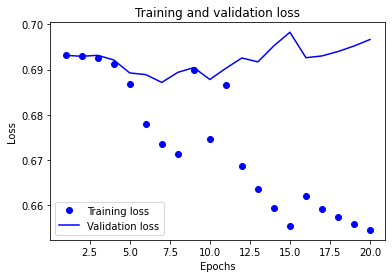

In [51]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

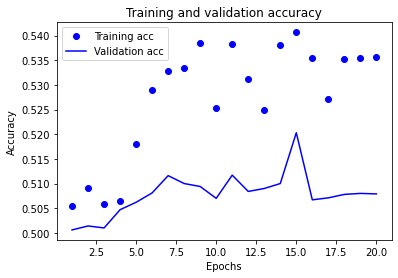

In [52]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## padding pre

In [53]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [54]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [55]:
model1 = Sequential()
model1.add(Embedding(vocab_size, word_vector_dim, input_shape = (None,)))
model1.add(LSTM(32))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))

model1.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 167,361
Trainable params: 167,361
Non-trainable params: 0
_________________________________________________________________


In [56]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 
history1 = model1.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 49ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6934 - val_accuracy: 0.5015
Epoch 2/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6929 - accuracy: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.5009
Epoch 3/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6924 - accuracy: 0.5121 - val_loss: 0.6925 - val_accuracy: 0.5053
Epoch 4/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6928 - accuracy: 0.5078 - val_loss: 0.6926 - val_accuracy: 0.5056
Epoch 5/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6905 - accuracy: 0.5223 - val_loss: 0.6919 - val_accuracy: 0.5036
Epoch 6/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6878 - accuracy: 0.5192 - val_loss: 0.6920 - val_accuracy: 0.5038
Epoch 7/20
30/30 [==============================] - 1s 34ms/step - loss: 0.6827 - accuracy: 0.5234 - val_loss: 0.6912 - val_accuracy: 0.5041
Epoch 8/20
30

In [57]:
results1 = model1.evaluate(x_test,  y_test, verbose=2)

print(results1)

782/782 - 5s - loss: 0.7133 - accuracy: 0.5104
[0.7132612466812134, 0.5103600025177002]


In [58]:
history_dict1 = history1.history
print(history_dict1.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


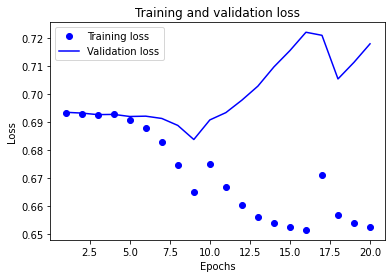

In [59]:
import matplotlib.pyplot as plt

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

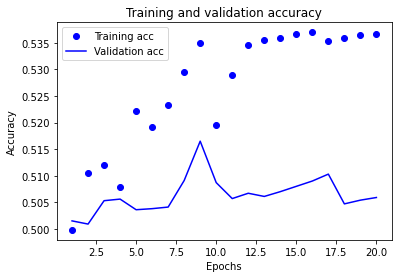

In [60]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Word2Vec

In [64]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [74]:
import os
os.mkdir(os.getenv('HOME')+'/aiffel/exp6/data/')

In [91]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/exp6/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) #특수문자 4개 제거

8

In [92]:
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i,:])))))
f.close

<function TextIOWrapper.close()>

In [93]:
vectors[0,:]

array([-0.0452108 , -0.0328973 , -0.0284947 , -0.07605503,  0.01696626,
        0.01589185, -0.00109424,  0.0569349 , -0.02909484,  0.03698552,
       -0.01809493, -0.01431333,  0.04716642,  0.01935077,  0.04009499,
       -0.00030036], dtype=float32)

임베딩 파라미터를 읽어서 word vector로 활용

In [101]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.00196702, -0.05760687,  0.0129189 , -0.0149007 , -0.04543651,
       -0.01677785, -0.02721151, -0.0054094 ,  0.01907246,  0.0514057 ,
        0.0032226 , -0.00532879, -0.04288022, -0.01880499,  0.01456789,
        0.02377662], dtype=float32)

In [99]:
word_vectors.similar_by_word("love")

[('slightly', 0.9409744143486023),
 ('stands', 0.9285807609558105),
 ('betty', 0.9210562109947205),
 ('journey', 0.9195317625999451),
 ('fate', 0.91553795337677),
 ("movie's", 0.9139606952667236),
 ('reaching', 0.9121611714363098),
 ('hardened', 0.9118157625198364),
 ('may', 0.9113243818283081),
 ('crime', 0.9099340438842773)]

In [102]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/exp6/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary = True, limit=1000000)

vector = word2vec['computer']
vector

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [103]:
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [104]:
vocab_size = 10000
word_vector_dim = 300
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

In [105]:
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [106]:
from tensorflow.keras.initializers import Constant

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix),
                   input_length=maxlen,
                   trainable = True))
model.add(Conv1D(16, 7, activation = 'relu'))
model.add(MaxPooling1D(6))
model.add(Conv1D(16, 7, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 95, 16)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 89, 16)            1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [107]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 14s 192ms/step - loss: 0.6987 - accuracy: 0.5413 - val_loss: 0.6870 - val_accuracy: 0.5345
Epoch 2/20
30/30 [==============================] - 5s 155ms/step - loss: 0.6746 - accuracy: 0.5958 - val_loss: 0.6681 - val_accuracy: 0.6096
Epoch 3/20
30/30 [==============================] - 5s 158ms/step - loss: 0.6333 - accuracy: 0.6794 - val_loss: 0.6057 - val_accuracy: 0.7021
Epoch 4/20
30/30 [==============================] - 5s 159ms/step - loss: 0.4869 - accuracy: 0.7987 - val_loss: 0.3874 - val_accuracy: 0.8293
Epoch 5/20
30/30 [==============================] - 5s 158ms/step - loss: 0.3145 - accuracy: 0.8690 - val_loss: 0.3203 - val_accuracy: 0.8640
Epoch 6/20
30/30 [==============================] - 5s 157ms/step - loss: 0.2426 - accuracy: 0.9050 - val_loss: 0.2996 - val_accuracy: 0.8749
Epoch 7/20
30/30 [==============================] - 5s 155ms/step - loss: 0.1682 - accuracy: 0.9437 - val_loss: 0.2947 - val_accuracy: 0.8801
Epoch

In [108]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 2s - loss: 0.4587 - accuracy: 0.8648
[0.45870813727378845, 0.8648399710655212]
